# Intro to RNN

Let's prepare a simple sequence of numbers and build an RNN 

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

data = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
print("Data: ", data.shape, "\n\n", data)

In [ ]:
# Number of features used as input. (Number of columns)
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 5
# Number of features in last hidden state ie. number of output time-
# steps to predict.See image below for more clarity.
HIDDEN_SIZE = 2
# Number of stacked rnn layers.
NUM_LAYERS = 1
# We have total of 20 rows in our input. 
# We divide the input into 4 batches where each batch has only 1
# row. Each row corresponds to a sequence of length 5. 
BATCH_SIZE = 4

In [ ]:
# Initialize the RNN.
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = 1, batch_first=True)
# input size : (batch, seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)
# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
for i in range(100):
    out, h_n = rnn(inputs)

In [ ]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)

# Time Series Forecasting
On windows,you will need to either install wget utilities for windows or download the file using the link and save it in an accessible folder.

In [ ]:
!wget https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
covid_data = pd.read_csv("coviddata.csv")
covid_data

dateRep  day  month  year  cases  deaths countriesAndTerritories  \
0      14/12/2020   14     12  2020    746       6             Afghanistan   
1      13/12/2020   13     12  2020    298       9             Afghanistan   
2      12/12/2020   12     12  2020    113      11             Afghanistan   
3      11/12/2020   11     12  2020     63      10             Afghanistan   
4      10/12/2020   10     12  2020    202      16             Afghanistan   
...           ...  ...    ...   ...    ...     ...                     ...   
61895  25/03/2020   25      3  2020      0       0                Zimbabwe   
61896  24/03/2020   24      3  2020      0       1                Zimbabwe   
61897  23/03/2020   23      3  2020      0       0                Zimbabwe   
61898  22/03/2020   22      3  2020      1       0                Zimbabwe   
61899  21/03/2020   21      3  2020      1       0                Zimbabwe   

      geoId countryterritoryCode  popData2019 continentExp  \
0        AF                  AFG   38041757.0         Asia   
1        AF                  AFG   38041757.0         Asia   
2        AF                  AFG   38041757.0         Asia   
3        AF                  AFG   38041757.0         Asia   
4        AF                  AFG   38041757.0         Asia   
...     ...                  ...          ...          ...   
61895    ZW                  ZWE   14645473.0       Africa   
61896    ZW                  ZWE   14645473.0       Africa   
61897    ZW                  ZWE   14645473.0       Africa   
61898    ZW                  ZWE   14645473.0       Africa   
61899    ZW                  ZWE   14645473.0       Africa   

       Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
0                                               9.013779           
1                                               7.052776           
2                                               6.868768           
3                                               7.134266           
4                                               6.968658           
...                                                  ...           
61895                                                NaN           
61896                                                NaN           
61897                                                NaN           
61898                                                NaN           
61899                                                NaN           

[61900 rows x 12 columns]

In [3]:
data = covid_data[covid_data['countryterritoryCode']=='USA'][['dateRep', 'cases']]
data

dateRep   cases
59001  14/12/2020  189723
59002  13/12/2020  216017
59003  12/12/2020  234633
59004  11/12/2020  224680
59005  10/12/2020  220025
...           ...     ...
59346  04/01/2020       0
59347  03/01/2020       0
59348  02/01/2020       0
59349  01/01/2020       0
59350  31/12/2019       0

[350 rows x 2 columns]

In [4]:
data['dateRep'] = pd.to_datetime(data['dateRep'], format="%d/%m/%Y")
data = data.sort_values(by="dateRep", key=pd.to_datetime)
data = data.set_index('dateRep')

dateRep   cases
59001 2020-12-14  189723
59002 2020-12-13  216017
59003 2020-12-12  234633
59004 2020-12-11  224680
59005 2020-12-10  220025
...          ...     ...
59346 2020-01-04       0
59347 2020-01-03       0
59348 2020-01-02       0
59349 2020-01-01       0
59350 2019-12-31       0

[350 rows x 2 columns]

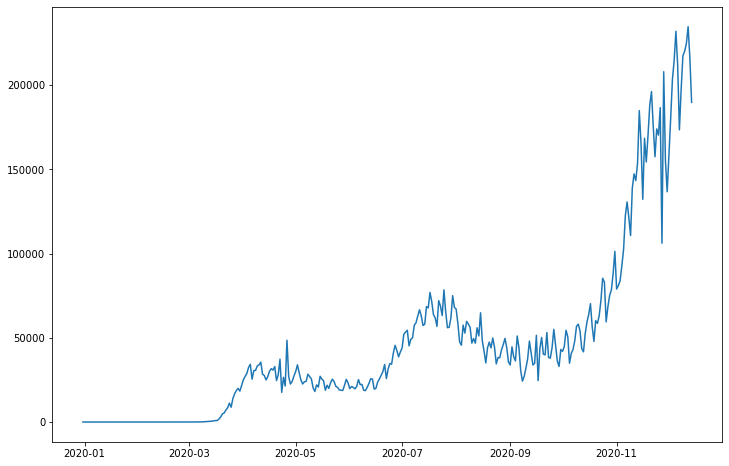

In [8]:
fig = plt.gcf().set_size_inches(12,8)

plt.plot(data, label = 'Covid-19 Cases in the US')
plt.show()

In [9]:
training_data = data.values.copy()

In [10]:
def chunkify(data, seq_length):
    chunks = []
    targets = []

    for i in range(len(data)-seq_length-1):
        chunks.append(data[i:(i+seq_length)])
        targets.append(data[i+seq_length])

    return np.array(chunks),np.array(targets)

chunkify([[1],[2],[3],[4],[5],[6]],3)
# np.arange(100).reshape(-1,1)

(array([[[1],
         [2],
         [3]],
 
        [[2],
         [3],
         [4]]]),
 array([[4],
        [5]]))

In [65]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data.values.copy())

seq_length = 5
x, y = chunkify(training_data, seq_length)

train_size = int(len(y) * 1)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [12]:
class CovidPrediction(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(CovidPrediction, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fully_connected = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        ula, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fully_connected(h_out)
        return out

In [67]:
num_epochs = 5000
learning_rate = 0.01
model = CovidPrediction(1, 1, 2, 1)

criterion = torch.nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch%100==0:
        print("Iteration: %d, loss:%f" % (epoch, loss.item()))

Iteration: 0, loss:0.262190
Iteration: 100, loss:0.004566
Iteration: 200, loss:0.001994
Iteration: 300, loss:0.001588
Iteration: 400, loss:0.001430
Iteration: 500, loss:0.001357
Iteration: 600, loss:0.001321
Iteration: 700, loss:0.001300
Iteration: 800, loss:0.001287
Iteration: 900, loss:0.001276
Iteration: 1000, loss:0.001267
Iteration: 1100, loss:0.001259
Iteration: 1200, loss:0.001251
Iteration: 1300, loss:0.001243
Iteration: 1400, loss:0.001235
Iteration: 1500, loss:0.001227
Iteration: 1600, loss:0.001219
Iteration: 1700, loss:0.001211
Iteration: 1800, loss:0.001202
Iteration: 1900, loss:0.001193
Iteration: 2000, loss:0.001183
Iteration: 2100, loss:0.001172
Iteration: 2200, loss:0.001161
Iteration: 2300, loss:0.001150
Iteration: 2400, loss:0.001138
Iteration: 2500, loss:0.001126
Iteration: 2600, loss:0.001115
Iteration: 2700, loss:0.001104
Iteration: 2800, loss:0.001094
Iteration: 2900, loss:0.001084
Iteration: 3000, loss:0.001076
Iteration: 3100, loss:0.001070
Iteration: 3200, los

# Predicting for arbitrary values

In [33]:
chunkify([[24882],[25320], [26291], [24492], [28903], [39276], [0]], 5)

(array([[[24882],
         [25320],
         [26291],
         [24492],
         [28903]]]),
 array([[39276]]))

In [44]:
# testx, testy = chunkify([[22854], [23285], [24882], [25320], [26291], [24492], [28903], [39276]], 2)

testx, testy = chunkify([[24882],[25320], [26291], [27492], [28903], [39276], [0],[0]], 5)
testX = Variable(torch.Tensor(np.array(testx)))
testY = Variable(torch.Tensor(np.array(testy)))

In [45]:
testX

tensor([[[24882.],
         [25320.],
         [26291.],
         [27492.],
         [28903.]],

        [[25320.],
         [26291.],
         [27492.],
         [28903.],
         [39276.]]])

In [46]:
model.eval()
test_predict = model(testX).data.numpy()
test_actual = testY.data.numpy()

In [47]:
test_actual

array([[39276.],
       [    0.]], dtype=float32)

In [48]:
test_predict = sc.inverse_transform(test_predict)
test_predict

array([[93683.29],
       [93683.29]], dtype=float32)

In [ ]:
plt.axvline(x=3, c='r', linestyle='--')

plt.plot(test_actual)
plt.plot(test_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

# Predicting on Training Data

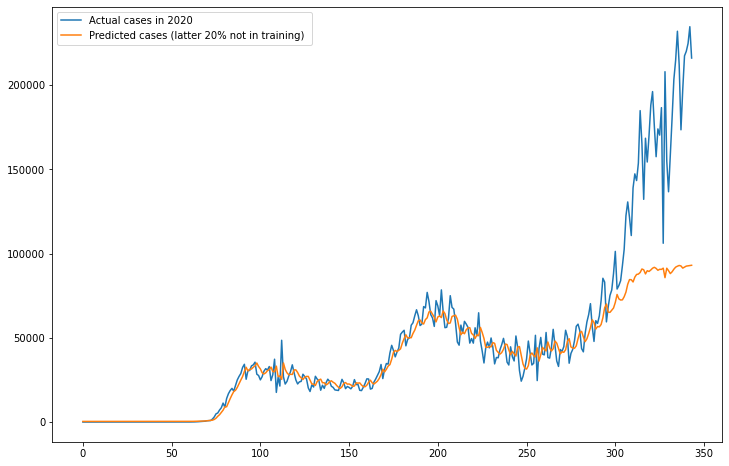

In [58]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
data_actual = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_actual = sc.inverse_transform(data_actual)

# plt.axvline(x=train_size, c='r', linestyle='--')
fig = plt.gcf().set_size_inches(12,8)
plt.plot(data_actual)
plt.plot(data_predict)
plt.suptitle('')
plt.legend(['Actual cases in 2020', 'Predicted cases (latter 20% not in training) '], loc='upper left')

# Using model to predict another country

In [61]:
data = covid_data[covid_data['countryterritoryCode']=='IND'][['dateRep', 'cases']]
data['dateRep'] = pd.to_datetime(data['dateRep'], format="%d/%m/%Y")
data = data.sort_values(by="dateRep", key=pd.to_datetime)
data = data.set_index('dateRep')

In [69]:
sc = MinMaxScaler()
seq_length = 5
training_data = sc.fit_transform(data.values.copy())
x, y = chunkify(training_data, seq_length)
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))


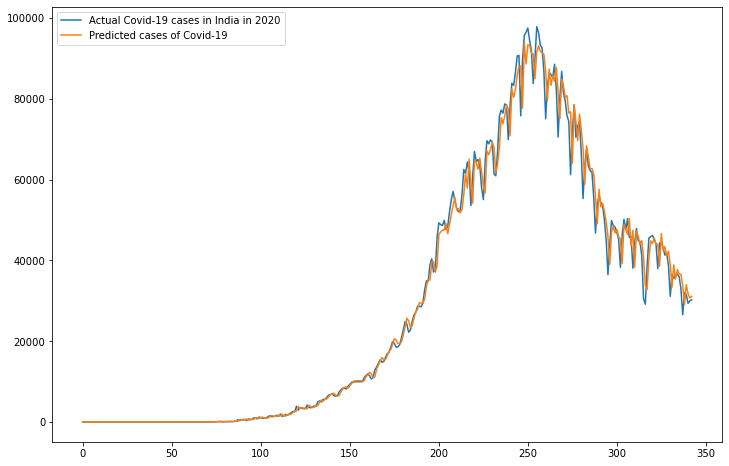

In [71]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
data_actual = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_actual = sc.inverse_transform(data_actual)

# plt.axvline(x=train_size, c='r', linestyle='--')
fig = plt.gcf().set_size_inches(12,8)
plt.plot(data_actual)
plt.plot(data_predict)
plt.suptitle('')
plt.legend(['Actual Covid-19 cases in India in 2020', 'Predicted cases of Covid-19'], loc='upper left')

# Sequence Generation

In [ ]:
import nltk
nltk.download()
# Resource punkt not found.

In [ ]:
import torch
from torch import nn
import numpy as np

In [ ]:
from nltk.tokenize import sent_tokenize
filedata = open('alice.txt').readlines()

In [ ]:
filedata[4]

In [ ]:
text = []
for row in filedata:
    row = row.lower().strip()
    toks = sent_tokenize(row)
    text.extend(toks)
# sent_tokenize(filedata)

In [ ]:
# text = ['hey how are you','good i am fine','have a nice day']

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

In [ ]:
maxlen = len(max(text, key=len))
print("The longest string has {} characters".format(maxlen))

In [ ]:
# Padding

# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i])<maxlen:
        text[i] += ' '

In [ ]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    if len(text[i])>5:
        for ch in range(len(text[i])-5):
            input_seq.append(text[i][ch:ch+5])
            target_seq.append(text[i][ch+5:])
            print (text[i][:ch+5], ">", text[i][ch+5:])
        
#     input_seq.append(text[i][:-1])
#     target_seq.append(text[i][1:])
    
#     print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))
    if i>20:
        break

In [ ]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [ ]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [ ]:
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq.shape))

In [ ]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [ ]:
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Training Run
input_seq = input_seq.to(device)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(input_seq)
    output = output.to(device)
    target_seq = target_seq.to(device)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

In [ ]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character = character.to(device)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden


In [ ]:
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [ ]:
sample(model, 15, 'thought alice ')

In [ ]:
start = "thought Al"
answer = start
for i in range(50):
    start = sample(model, 15, start)
    print (start)